# HERE traffic4cast data

In [10]:
import os
import h5py
import sys
import numpy as np

import torch
from dotenv import load_dotenv

load_dotenv()


REPO_ROOT = os.environ["REPO_ROOT"]

DATA_ROOT = os.path.abspath(os.path.join(REPO_ROOT,  os.environ["DATA_ROOT"])) # for notebooks we need absolute path



**The h5 format and fitting pytorch models**

"Hierarchical Data Format (HDF) is a set of file formats (HDF4, HDF5) designed to store and organize large amounts of data."(https://en.wikipedia.org/wiki/Hierarchical_Data_Format).


For pytorch we need **tensors**.

**Example of transformation of one file from h5 to numpy**

In [11]:
RAW_DATA = os.path.join(DATA_ROOT, 'BERLIN', 'BERLIN', 'training')
example_data_path = os.path.join(RAW_DATA, "2019-01-29_BERLIN_8ch.h5")

In [12]:
import numpy as np
# FILE READING 
with h5py.File(example_data_path, "r") as f:
    dset = f["array"]
    did = dset.id

    # Get shape via low-level space object
    space = did.get_space()
    dims = space.get_simple_extent_dims()  # returns a tuple of dims
    shape = tuple(dims)
    print("Shape from file:", shape)

    # Allocate a normal float64 numpy array with that shape
    arr64 = np.empty(shape, dtype=np.float64)

    # Read from file into our float64 array
    # read(mspace, fspace, buf, mtype=None, dxpl=None)
    did.read(h5py.h5s.ALL, h5py.h5s.ALL, arr64)


Shape from file: (288, 495, 436, 8)


In [13]:
# Check nans
np.isnan(arr64).any()

np.False_

**Data transformations**
- Pytorch models expect (time_slots, chanels, height, width)
- We have a big amount of data so we need to consider memory. For that we cast the data to float32.
- We need tensors.


In [14]:
# Cast to float32
arr = arr64.astype(np.float32)

# Move channels last -> second axis: (T, H, W, C) -> (T, C, H, W)
arr = np.moveaxis(arr, -1, 1)

# Convert to torch tensor
X_torch = torch.tensor(arr, dtype=torch.float32)

# print(X_torch)
print(X_torch.shape)

torch.Size([288, 8, 495, 436])


**Visualization of max data density in one day**

Best t: 195 with fraction>0: 0.11255676026318229


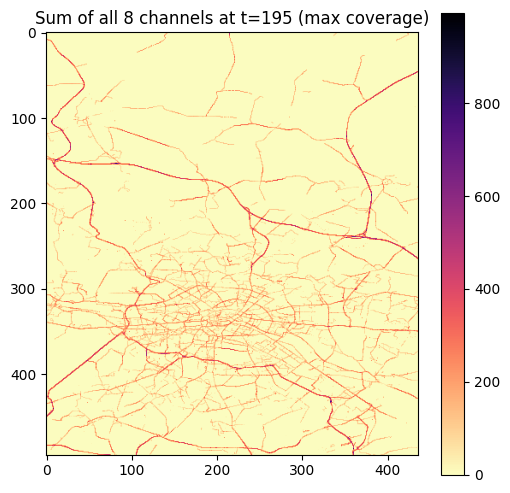

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# sum ALL 8 channels
fractions = []
for t in range(X_torch.shape[0]):
    x = X_torch[t].cpu().numpy()        # (8, H, W)
    sum_all = x.sum(axis=0)             # (H, W)
    frac = (sum_all > 0).mean()
    fractions.append(frac)

best_t = int(np.argmax(fractions))
print("Best t:", best_t, "with fraction>0:", fractions[best_t])

t = best_t

x = X_torch[t].cpu().numpy()            # (8, H, W)
sum_all = x.sum(axis=0)                 # (H, W)

plt.figure(figsize=(6, 6))
plt.title(f"Sum of all 8 channels at t={t} (max coverage)")
plt.imshow(sum_all, cmap="magma_r")
plt.colorbar()
plt.show()


**visualizing a whole day**

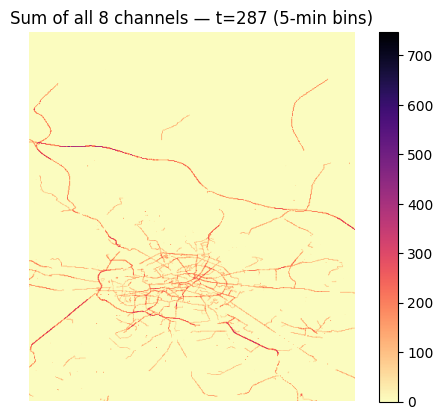

In [24]:
from IPython.display import clear_output
import numpy as np
import time
import matplotlib.pyplot as plt

T = X_torch.shape[0]

plt.figure(figsize=(7, 7))

for t in range(T):
    clear_output(wait=True)

    # sum ALL 8 channels at time t
    x = X_torch[t].cpu().numpy()     # (8, H, W)
    frame = x.sum(axis=0)            # (H, W)

    plt.imshow(frame, cmap="magma_r")
    plt.title(f"Sum of all 8 channels — t={t} (5-min bins)")
    plt.axis("off")
    plt.colorbar()
    plt.show()

    time.sleep(0.1)


## Reducing the bbox

**bbox Berlin**

 13.189–13.625 / 52.359–52.854

In [25]:
import folium
from shared.utils.data_reduction import min_lat, max_lat, min_lon, max_lon

def show_bbox(lat_min, lat_max, lon_min, lon_max, zoom=11):
    """
    Muestra un mapa folium con la bounding box sin guardarlo en archivo.
    """
    center_lat = (lat_min + lat_max) / 2
    center_lon = (lon_min + lon_max) / 2

    m = folium.Map(location=[center_lat, center_lon], zoom_start=zoom)

    folium.Rectangle(
        bounds=[[lat_min, lon_min], [lat_max, lon_max]],
        color="red",
        weight=2,
        fill=False,
    ).add_to(m)

    return m


show_bbox(min_lat, max_lat, min_lon, max_lon)



**We want to reduce it to only the center of Berlin**

In [5]:
import folium

from shared.utils.data_reduction import sub_min_lat, sub_max_lon, sub_max_lat, sub_min_lon, max_lat, max_lon, min_lat, min_lon

# ----- center of the subarea -----
center_lat = (sub_min_lat + sub_max_lat) / 2
center_lon = (sub_min_lon + sub_max_lon) / 2

# ----- create folium map -----
m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# rectangle showing the reduced grid area
folium.Rectangle(
    bounds=[
        [sub_min_lat, sub_min_lon],  # SW corner
        [sub_max_lat, sub_max_lon],  # NE corner
    ],
    fill=False,
    color="red",
    weight=2,
).add_to(m)

# optionally also draw the full grid extent for reference
folium.Rectangle(
    bounds=[
        [min_lat, min_lon],
        [max_lat, max_lon],
    ],
    fill=False,
    color="blue",
    weight=1,
).add_to(m)

m


**visualize the mask**

Static shape: (9, 128, 128)


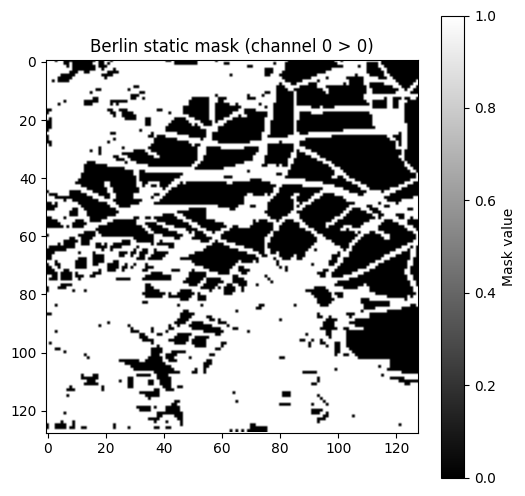

In [18]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

path = r"C:\Users\user\UPM\Imperial-4año\IoT\Github\BERLIN\BERLIN\BERLIN_static.h5"
path = r"C:\Users\user\UPM\Imperial-4año\IoT\Github\hugging_face\BERLIN_reduced\BERLIN_static.h5"

with h5py.File(path, "r") as f:
    static = f["array"][()]        # (C, H, W)

print("Static shape:", static.shape)

# mask is almost always channel 0
mask = static[0]                  # (H, W)

# convert to binary mask (0/1)
binary_mask = (mask > 0).astype(np.uint8)


plt.figure(figsize=(6, 6))
plt.title("Berlin static mask (channel 0 > 0)")
plt.imshow(binary_mask, cmap="gray")
plt.colorbar(label="Mask value")
plt.show()



**Range of the 4 channels acrross a day**

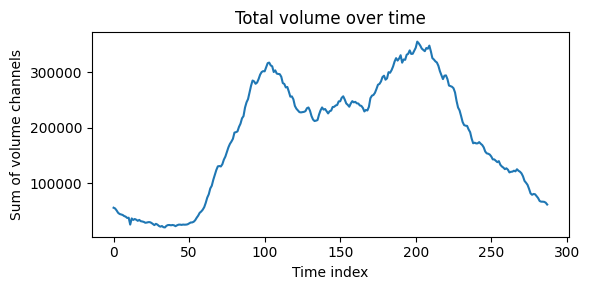

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# X_torch: (T, C, H, W)
# Volume channels are 0, 2, 4, 6

T = X_torch.shape[0]
time_idx = np.arange(T)

# Select only volume channels
volumes = X_torch[:, [0, 2, 4, 6]]  # (T, 4, H, W)

# Sum over volume channels + spatial dims
y_vol = volumes.sum(dim=(1, 2, 3)).cpu().numpy()

plt.figure(figsize=(6, 3))
plt.plot(time_idx, y_vol)
plt.xlabel("Time index")
plt.ylabel("Sum of volume channels")
plt.title("Total volume over time")
plt.tight_layout()
plt.show()


**Range of each channel**

Channel 0: min = 0.00, max = 255.00
Channel 1: min = 0.00, max = 255.00
Channel 2: min = 0.00, max = 255.00
Channel 3: min = 0.00, max = 255.00
Channel 4: min = 0.00, max = 255.00
Channel 5: min = 0.00, max = 255.00
Channel 6: min = 0.00, max = 255.00
Channel 7: min = 0.00, max = 255.00


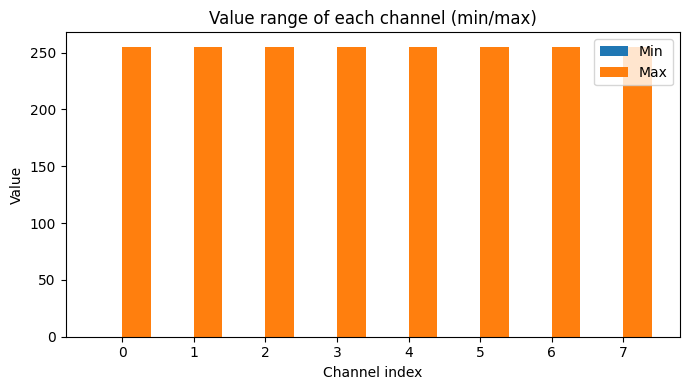

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# X_torch: (T, C, H, W)

C = X_torch.shape[1]
mins = []
maxs = []

for c in range(C):
    vals = X_torch[:, c].cpu().numpy()
    mins.append(vals.min())
    maxs.append(vals.max())

# Print numeric ranges
for c in range(C):
    print(f"Channel {c}: min = {mins[c]:.2f}, max = {maxs[c]:.2f}")

# Bar plot of ranges
plt.figure(figsize=(7,4))
plt.bar(np.arange(C)-0.2, mins, width=0.4, label="Min")
plt.bar(np.arange(C)+0.2, maxs, width=0.4, label="Max")
plt.xlabel("Channel index")
plt.ylabel("Value")
plt.title("Value range of each channel (min/max)")
plt.legend()
plt.tight_layout()
plt.show()
